# Fixed-Bed Column Breakthrough Analysis

**Project:** Modeling of pollutant removal in a continuous fixed-bed column study.
**Method:** Non-linear regression of breakthrough curves ($C_t/C_0$ vs. Time).
**Author:** PhD Candidate, Chemical Engineering

## 1. Thomas Model
Assumes second-order reversible reaction kinetics and Langmuir isotherm. It is used to determine the maximum solid-phase concentration ($q_0$) and the Thomas rate constant ($k_{Th}$).

$$\frac{C_t}{C_0} = \frac{1}{1 + \exp\left( \frac{k_{Th} q_0 m}{Q} - k_{Th} C_0 t \right)}$$

## 2. Yoon-Nelson Model
Based on the assumption that the rate of decrease in the probability of adsorption for each adsorbate molecule is proportional to the probability of adsorbate adsorption and the probability of adsorbate breakthrough on the adsorbent.

$$\frac{C_t}{C_0} = \frac{1}{1 + \exp\left( k_{YN} (\tau - t) \right)}$$

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# ==========================================
# 1. Plotting Configuration (Publication Quality)
# ==========================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset': 'cm'
})

print(" Libraries loaded and plotting style configured.")

 Libraries loaded and plotting style configured.


In [4]:
# ==========================================
# 2. Experimental Conditions (Global Constants)
# ==========================================
# Update these values according to your experimental setup
M_ADSORBENT = 2.0    # Mass of adsorbent (g)
Q_FLOW = 5.0         # Flow rate (mL/min)
C_INLET = 50.0       # Inlet concentration (mg/L) - C0
BED_HEIGHT = 10.0    # Bed height (cm)

# ==========================================
# 3. Data Loading from Excel
# ==========================================
filename = 'column_data.xlsx'

try:
    # Read the Excel file
    df = pd.read_excel(filename)
    print(f" Excel file '{filename}' loaded successfully.")

    # Extract columns (Ensure these match your Excel headers)
    t_data = df['Time'].values
    C_eff = df['C_eff'].values

    # Calculate Normalized Concentration (Ct / C0)
    y_data = C_eff / C_INLET

    # Data Cleaning: Clip values between 0 and 1 (to handle experimental noise)
    y_data = np.clip(y_data, 0, 1.0)

    print(f" Data Points Loaded: {len(t_data)}")

except FileNotFoundError:
    print(f" Error: File '{filename}' not found. Please ensure the file exists in the directory.")
    raise

 Excel file 'column_data.xlsx' loaded successfully.
 Data Points Loaded: 29


In [5]:
# ==========================================
# 4. Model Definitions
# ==========================================

def thomas_model(t, kTh, q0):
    """
    Thomas Model Equation
    t: time (min)
    kTh: Thomas rate constant (mL/min.mg)
    q0: Equilibrium uptake (mg/g)
    """
    # Term calculation
    term1 = (kTh * q0 * M_ADSORBENT) / Q_FLOW
    term2 = kTh * C_INLET * t

    exponent = term1 - term2

    # Overflow protection for exp()
    exponent = np.clip(exponent, -100, 100)
    return 1 / (1 + np.exp(exponent))

def yoon_nelson_model(t, kYN, tau):
    """
    Yoon-Nelson Model Equation
    t: time (min)
    kYN: Rate constant (1/min)
    tau: Time required for 50% adsorbate breakthrough (min)
    """
    exponent = kYN * (tau - t)

    # Overflow protection
    exponent = np.clip(exponent, -100, 100)
    return 1 / (1 + np.exp(exponent))

--- Running Non-Linear Regression ---
\n Thomas Model Results (R² = 0.9981):
   Rate Constant (k_Th)      = 0.00079 mL/(min.mg)
   Adsorption Capacity (q_0) = 15993.65 mg/g
\n Yoon-Nelson Model Results (R² = 0.9981):
   Rate Constant (k_YN)      = 0.0393 1/min
   Time to 50% (tau)         = 127.95 min
\n Plot saved as 'Breakthrough_Model_Fit.png'


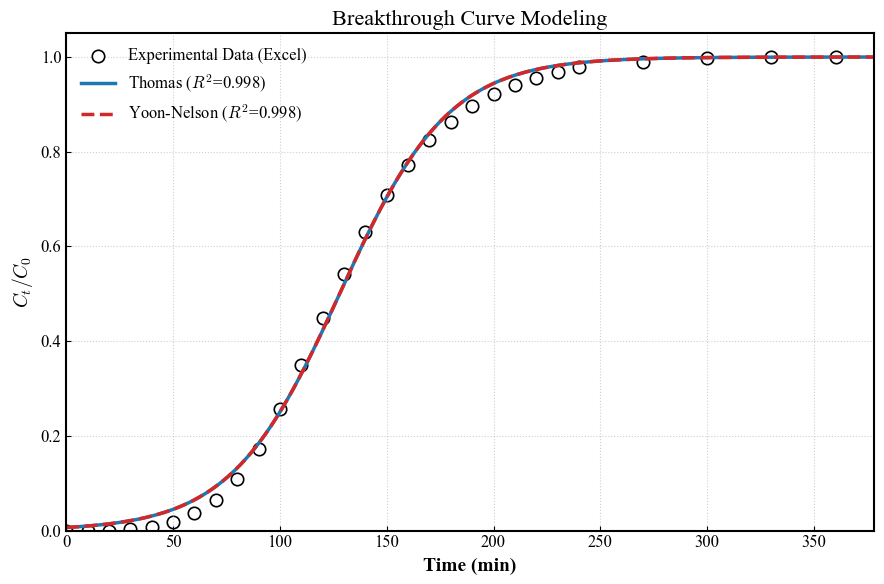

In [6]:
print("--- Running Non-Linear Regression ---")

# ==========================================
# 5. Curve Fitting (Optimization)
# ==========================================

# --- A. Fit Thomas Model ---
# Initial Guesses: kTh=0.01, q0=100
try:
    popt_th, pcov_th = curve_fit(thomas_model, t_data, y_data, p0=[0.01, 100], bounds=(0, np.inf))
    kTh_fit, q0_fit = popt_th

    # Calculate R-squared
    y_pred_th = thomas_model(t_data, *popt_th)
    r2_th = r2_score(y_data, y_pred_th)

    print(f"\\n Thomas Model Results (R² = {r2_th:.4f}):")
    print(f"   Rate Constant (k_Th)      = {kTh_fit:.5f} mL/(min.mg)")
    print(f"   Adsorption Capacity (q_0) = {q0_fit:.2f} mg/g")
except Exception as e:
    print(f" Thomas fit failed: {e}")
    popt_th = None

# --- B. Fit Yoon-Nelson Model ---
# Initial Guesses: kYN=0.1, tau=50 (approximate breakthrough time)
try:
    popt_yn, pcov_yn = curve_fit(yoon_nelson_model, t_data, y_data, p0=[0.1, 50], bounds=(0, np.inf))
    kYN_fit, tau_fit = popt_yn

    y_pred_yn = yoon_nelson_model(t_data, *popt_yn)
    r2_yn = r2_score(y_data, y_pred_yn)

    print(f"\\n Yoon-Nelson Model Results (R² = {r2_yn:.4f}):")
    print(f"   Rate Constant (k_YN)      = {kYN_fit:.4f} 1/min")
    print(f"   Time to 50% (tau)         = {tau_fit:.2f} min")
except Exception as e:
    print(f" Yoon-Nelson fit failed: {e}")
    popt_yn = None

# ==========================================
# 6. Visualization
# ==========================================
# Generate smooth time array for model lines
t_smooth = np.linspace(0, max(t_data)*1.1, 200)

plt.figure(figsize=(9, 6))

# Plot Experimental Data
plt.scatter(t_data, y_data, color='black', s=80, facecolors='white',
            edgecolors='black', linewidth=1.2, label='Experimental Data (Excel)')

# Plot Thomas Model
if popt_th is not None:
    plt.plot(t_smooth, thomas_model(t_smooth, *popt_th), '#1f77b4', linewidth=2.5,
             label=f'Thomas ($R^2$={r2_th:.3f})')

# Plot Yoon-Nelson Model
if popt_yn is not None:
    plt.plot(t_smooth, yoon_nelson_model(t_smooth, *popt_yn), '#d62728', linestyle='--', linewidth=2.5,
             label=f'Yoon-Nelson ($R^2$={r2_yn:.3f})')

# Graph Styling
plt.xlabel('Time (min)', fontweight='bold', fontsize=14)
plt.ylabel(r'$C_t / C_0$', fontweight='bold', fontsize=14)
plt.title('Breakthrough Curve Modeling', fontsize=16)
plt.legend(frameon=False, fontsize=12, loc='best')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim(0, max(t_data)*1.05)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.savefig('Breakthrough_Model_Fit.png', dpi=600)
print(r"\n Plot saved as 'Breakthrough_Model_Fit.png'")
plt.show()